In [1]:
import sys

# Check if running on Google Colab
# If so, mount Google Drive and download CIFAR-10 dataset
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # assignment folder, e.g. 'cs231n/assignments/assignment1/'
    FOLDERNAME = 'DLvis/assignment1/'
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    # This downloads the CIFAR-10 dataset to your Drive
    # if it doesn't already exist.
    %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
    !bash get_datasets.sh
    %cd /content/drive/My\ Drive/$FOLDERNAME
# END OF COLAB SETUP

# If not running on Google Colab, download CIFAR-10 dataset locally
else:
    print("Not running on Google Colab")
    %cd ./cs231n/datasets/
    !bash get_datasets.sh
    %cd ../..

Running on Google Colab
Mounted at /content/drive
/content/drive/My Drive/DLvis/assignment1/cs231n/datasets
/content/drive/My Drive/DLvis/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://eva.fing.edu.uy/mod/assign/view.php?id=194303) on the course website.*

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.294787
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Como los pesos son aleatorios, la probabilidad de que una instancia sea de una determinada clase será aproximadamente 0.1 para todas las clases (Hay 10 clases). Por lo tanto para calcular la pérdida se suman N términos aprox. -log(0.1) y se divide entre N, lo que resulta en aproximadamente -log(0.1).



In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.908915 analytic: 0.908915, relative error: 3.053336e-09
numerical: 0.595070 analytic: 0.595070, relative error: 5.938281e-08
numerical: 0.989623 analytic: 0.989623, relative error: 2.782226e-08
numerical: 0.699173 analytic: 0.699173, relative error: 3.986355e-09
numerical: 1.630042 analytic: 1.630042, relative error: 4.179527e-09
numerical: 2.350315 analytic: 2.350315, relative error: 2.706598e-09
numerical: 1.836392 analytic: 1.836392, relative error: 2.023474e-08
numerical: -2.861520 analytic: -2.861520, relative error: 1.068604e-08
numerical: -3.218956 analytic: -3.218956, relative error: 1.040359e-08
numerical: -0.705569 analytic: -0.705569, relative error: 9.671237e-09
numerical: 2.776045 analytic: 2.776045, relative error: 1.896462e-08
numerical: 0.119706 analytic: 0.119707, relative error: 4.414985e-07
numerical: 0.333483 analytic: 0.333483, relative error: 5.878618e-08
numerical: 1.391052 analytic: 1.391052, relative error: 1.522146e-08
numerical: -2.017511 analyti

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.294787e+00 computed in 0.115683s
vectorized loss: 2.294787e+00 computed in 0.016879s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [9]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 786.418344
iteration 100 / 1500: loss 288.672962
iteration 200 / 1500: loss 106.865510
iteration 300 / 1500: loss 40.466277
iteration 400 / 1500: loss 16.161909
iteration 500 / 1500: loss 7.228079
iteration 600 / 1500: loss 3.977810
iteration 700 / 1500: loss 2.755515
iteration 800 / 1500: loss 2.398953
iteration 900 / 1500: loss 2.166918
iteration 1000 / 1500: loss 2.075015
iteration 1100 / 1500: loss 2.049689
iteration 1200 / 1500: loss 2.120227
iteration 1300 / 1500: loss 2.065808
iteration 1400 / 1500: loss 2.106613
That took 7.582223s


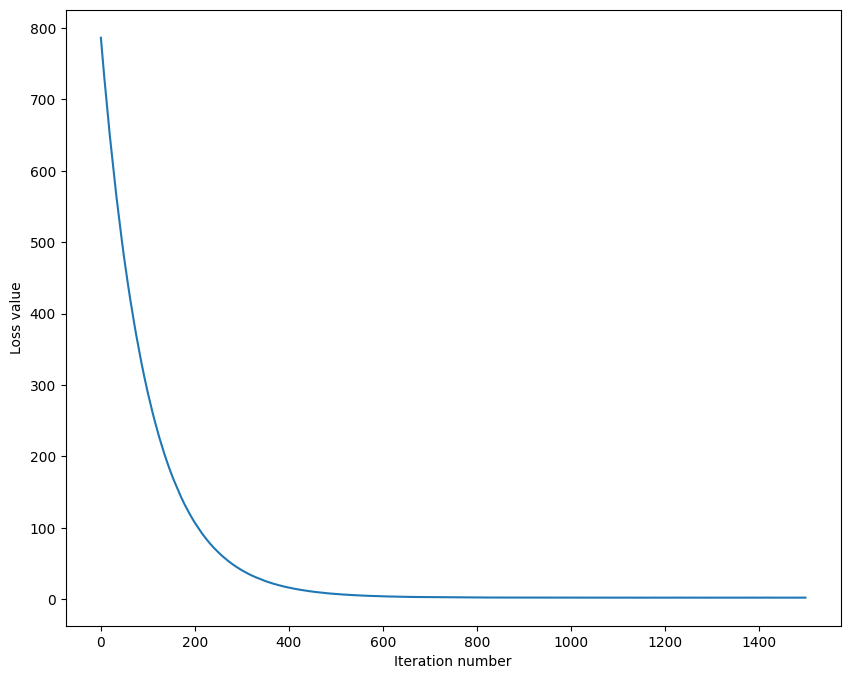

In [10]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [11]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.331388
validation accuracy: 0.354000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 2.5e4, 5e4, 7.5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regularization_strengths:
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)

    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    results[(lr, reg)] = np.mean(y_train_pred == y_train), np.mean(y_val_pred == y_val)

    if results[(lr, reg)][1] > best_val:
      best_val = results[(lr, reg)][1]
      best_softmax = softmax
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.301633 val accuracy: 0.297000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.329000 val accuracy: 0.342000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.308898 val accuracy: 0.327000
lr 5.000000e-08 reg 7.500000e+04 train accuracy: 0.294571 val accuracy: 0.311000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.352776 val accuracy: 0.366000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.324245 val accuracy: 0.340000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.303571 val accuracy: 0.325000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.291939 val accuracy: 0.307000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.357592 val accuracy: 0.373000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.330184 val accuracy: 0.335000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.291735 val accuracy: 0.302000
lr 5.000000e-07 reg 7.500000e+04 train accuracy: 0.303816 val accuracy: 0.314000
lr 1.000000e-06 reg 1.000000

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.365000


**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution:
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?


$\color{blue}{\textit Your Answer:}$ Los valores the T que harían que el modelo confíe más en sus predicciones son todos los T < 1. A medida que T disminuye la probabilidad de la clase más probable se acerca a 1 (y por lo tanto las otras se acercan a 0).

Por otro lado, cuando T > 1, a medida que T aumenta las probabilidades se acercan a las de una distribución uniforme, por lo que el modelo confía menos en sus predicciones.  

Cuando T = 1, se trata de un clasificador softmax estándar.


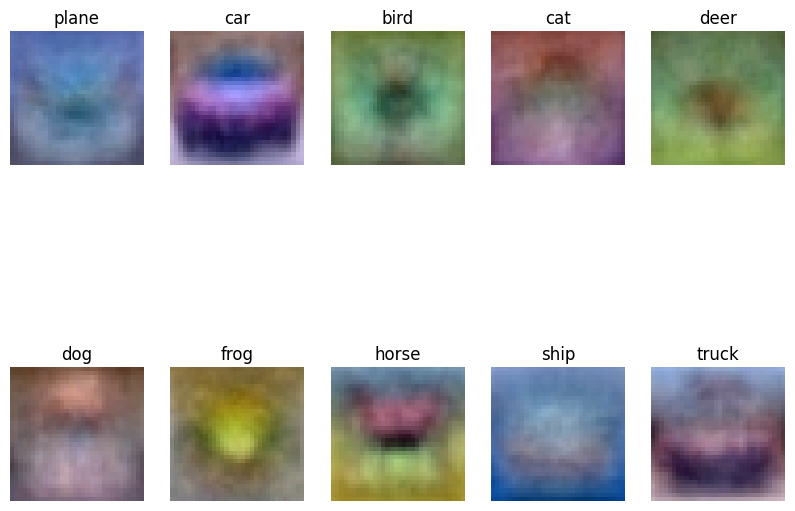

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])